# Example: Neural Networks with partitions

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [1]:
using Flux
using Flux: Chain, Dense, relu, mse, train!, params, ADAM
using Random
using Gogeta
using Plots
using Gurobi
using JuMP
using LaTeXStrings
using CSV
using DataFrames
using StatsBase
using LinearAlgebra
using StatsPlots

## Introduction

In this Jupyter notebook, we present a different way how to formulate a neural network as a MIP problem based on the follwing paper [[1]](https://arxiv.org/abs/2102.04373). The idea is that variables are split into $N$ non-overlapping sets – partitions. We are interested in the smallest number of partitions $N$ such that the bounds for the variables are as tight as possible.

At first, we will introduce you to the function itself and its parameters. Then we will its computation performance on an easy function. In the end, we will try applying this partition-based formulation on the real dataset.

Suppose we have next function to learn with NN:
$$f(x_1, x_2,x_3,x_4) = (x_1+x_2)^2/5 + (x_3-x_4)^2/10 - 5x_3x_1+x_2x_4/3$$
where $x_1\in[0, 1]$, $x_2\in[-0.5, 0.5]$, $x_3\in[1, 2]$, $x_4\in[0, 1]$


In [2]:
function f(x)
    return (x[1]+x[2])^2/5+(x[3]-x[4])^2/10 - 5*x[3]*x[1]+x[2]*x[4]/3
end

f (generic function with 1 method)

In [3]:
# this function will allow to generate random floar number in a range
g = (a, b) -> b + (a - b) * rand()

#1 (generic function with 1 method)

### Generate artificial dataset

In [4]:
dataset = zeros(10000, 5)
counter = 1

for i = 1:10000
    x = [g(0,1), g(-0.5, 0.5), g(1, 2), g(0,1)]
    dataset[i, :] = push!(x, f(x))
end

X = dataset[:, 1:4];
y = dataset[:, 5];

sample = randsubseq(1:size(dataset, 1), 0.7)
X_train = Array{Float32}(X[sample, :])';
y_train = Array{Float32}(y[sample, :])';

notsample = [i for i in 1:size(dataset,1) if isempty(searchsorted(sample, i))]
X_test= Array{Float32}(X[notsample, :])';
y_test = Array{Float32}(y[notsample, :])';

data_train = Flux.Data.DataLoader((X_train, y_train), batchsize=64);

### Train and test NN

epoch #10, training loss: 0.03534344583749771, test loss: 0.03674628213047981
epoch #20, training loss: 0.011996964924037457, test loss: 0.012595848180353642
epoch #30, training loss: 0.004544305149465799, test loss: 0.004821101203560829
epoch #40, training loss: 0.0014924032147973776, test loss: 0.0016382235335186124
epoch #50, training loss: 0.0007075649336911738, test loss: 0.0007977709174156189
epoch #60, training loss: 0.0004484120581764728, test loss: 0.0005004550912417471
epoch #70, training loss: 0.00033920424175448716, test loss: 0.00038103535189293325
epoch #80, training loss: 0.0004130305605940521, test loss: 0.0004401381011120975
epoch #90, training loss: 0.0005526994355022907, test loss: 0.0005781869404017925
epoch #100, training loss: 0.0003639565547928214, test loss: 0.000393056747270748
epoch #110, training loss: 0.00019165073172189295, test loss: 0.00022044584329705685
epoch #120, training loss: 0.00016347116616088897, test loss: 0.00018955623090732843
epoch #130, trai

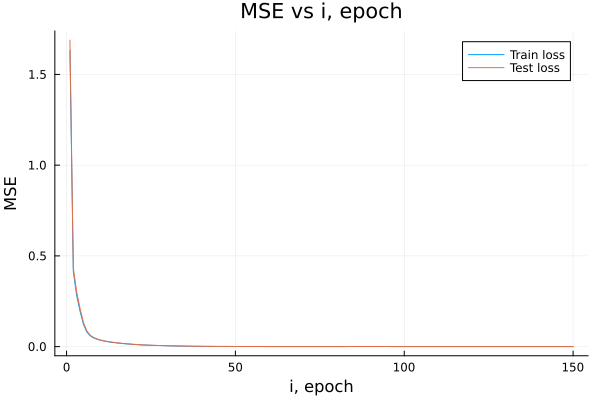

In [5]:
model = Chain(
    Dense(size(X)[2], 128, relu),
    Dense(128, 1),
)

loss(x, y) = Flux.mse(model(x), y)
opt = AdaBelief()
epochs = 150
train_losses = Float64[]
test_losses = Float64[]

for epoch in 1:epochs
    for (X_batch, y_batch) in data_train
        train!(loss, params(model), [(X_batch, y_batch)], opt);
    end
    push!(train_losses, loss(X_train, y_train));
    push!(test_losses, loss(X_test, y_test))
    if epoch%10 == 0
        println("epoch #", epoch, ", training loss: ", train_losses[end], ", test loss: ", test_losses[end])
    end
end

plot(train_losses, xlabel="i, epoch", ylabel="MSE", title="MSE vs i, epoch", label="Train loss")
plot!(test_losses, label="Test loss")

### Formulation of NN as a MIP using partiiton-based formulation

Once we have trained neural network, we need to innitialize empty `JuMp` model with `Gurobi`.


In [6]:
jump_model = Model(Gurobi.Optimizer);
set_silent(jump_model) #disables output of the optimazer
set_attribute(jump_model, "TimeLimit", 10) #sets the time limit to be 10 seconds

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


The formulation of NN is done with function `NN_formulate_Psplit!`. It has next set of input parameters</br>
<ul>
<li><code>jump_model</code>: The constraints and variables will be saved to this optimization model.</li>
<li><code>NN_model</code>: Neural network model to be formulated.</li>
<li><code>P</code>: The number of splits</li>
<li><code>U_in</code>: Upper bounds for the input variables.</li>
<li><code>L_in</code>: Lower bounds for the input variables.</li>
<li> <code>strategy</code> (optional): the way partitioning is done, possible options include: "equalsize", "equalrange", "random". Default is "equalsize".</li>
<li> <code>silent</code>(optional): Controls console ouput.</li>
<li><code>bound_tightening</code> (optional): possible options include: "standart", "precomputed", and "fast" (default)</li>
</ul>

There are some restrictions about the strategies for partitioning and architecture of the NN. NN can only have ReLU as activation function and no activation function in the last layer. With "equalrange" partition strategy, number of partitions should be greater or equal than 3. 

Formulation requires us to define lower and upper bounds for the input variables, we can find it using training set.

In [7]:
init_L, init_U = minimum.(eachrow(X_train)), maximum.(eachrow(X_train));

In [9]:
P = 4
println("Time to formulate NN as a JuMP model:")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);

Time to formulate NN as a JuMP model:
  3.566368 seconds (8.02 M allocations: 541.951 MiB, 4.03% gc time, 99.61% compilation time: 2% of which was recompilation)


Since we are interested in minimizing or maximizing the function $f$, we need to either minimize or maximize the output neuron. We have already explained how to get it in the previous Jupyter notebook related to neural networks.

In [10]:
# we are interested in the output neuron
output_neuron = jump_model[:x][maximum(keys(jump_model[:x].data))]

x[2,1]

Just for sake of criousity, lets look what are the minimum and maximum values of $f$ in the generated dataset

In [11]:
println("Minimum value in the dataset is ", minimum(dataset[:,5]))
println("x = ", dataset[argmin(dataset[:, 5]), 1:4])
println("Maximum value in the dataset is ", maximum(dataset[:,5]))
println("x = ", dataset[argmax(dataset[:, 5]), 1:4])

Minimum value in the dataset is -9.633691355200359
x = [0.9993248118097281, -0.28678758297803053, 1.950927441156575, 0.9383874261663949]
Maximum value in the dataset is 0.31715977389806377
x = [0.0015178642955678834, 0.39622854939011254, 1.7842382545280575, 0.08937482763080185]


In [12]:
@objective(jump_model, Min, output_neuron)
println("Time to minimize model:")
@time optimize!(jump_model)

println("The model found next solution:\n", value.(jump_model[:x][0, :]))
println("With objective function: ", objective_value(jump_model) )
solution = Float32.([i for i in value.(jump_model[:x][0, :])])
println("NN output: ", model(solution)[1], "\nTrue value of function: ", f(solution) )

Time to minimize model:
  0.916601 seconds (1.94 M allocations: 129.208 MiB, 1.88% gc time, 93.03% compilation time: 11% of which was recompilation)
The model found next solution:
  [1]  =  0.999863
  [2]  =  -0.499884
  [3]  =  1.99996
  [4]  =  0.999911
With objective function: -9.896524680238665
NN output: -9.896525
True value of function: -10.01502


In [13]:
@objective(jump_model, Max, output_neuron)
println("Time to maximize model:")
@time optimize!(jump_model)

println("The model found next solution:\n", value.(jump_model[:x][0, :]))
println("With objective function: ", objective_value(jump_model) )
solution = Float32.([i for i in value.(jump_model[:x][0, :])])
println("NN output: ", model(solution)[1], " \nTrue value of function: ", f(solution) )

Time to maximize model:
  0.201044 seconds (1.79 k allocations: 55.984 KiB)
The model found next solution:
  [1]  =  0.000165443
  [2]  =  0.270871
  [3]  =  1.99996
  [4]  =  9.12832e-5
With objective function: 0.38775522628799236
NN output: 0.38775498 
True value of function: 0.41299227


Approximation of the function found by the neural network is not perfect since the value produced by NN and true values are different, but the solutions found by partition based formulation are better than directly taking from the dataset. 

## Testing out different input parameters for partition based formulation

### Different number of partitions

Increasing the number of partitions, increases the size of the JuMP model.

In [14]:
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, 2, init_U, init_L);
jump_model

  0.041826 seconds (103.44 k allocations: 6.515 MiB, 83.68% compilation time)


A JuMP Model
Maximization problem with:
Variables: 517
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 129 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 261 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 1285 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 128 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, z_b, Σ

In [15]:
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, 3, init_U, init_L);
jump_model

  0.007084 seconds (84.16 k allocations: 5.048 MiB)


A JuMP Model
Maximization problem with:
Variables: 645
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 129 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 261 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 1797 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 128 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, z_b, Σ

In [16]:
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, 4, init_U, init_L);
jump_model

  0.008236 seconds (103.05 k allocations: 6.311 MiB)


A JuMP Model
Maximization problem with:
Variables: 773
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 129 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 261 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 2309 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 128 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, z_b, Σ

Make sure that the number of partitions is reasonable.

In [17]:
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, 5, init_U, init_L, silent = false);

Creating JuMP model...

LAYER 1

LAYER 2
  0.017072 seconds (110.59 k allocations: 6.737 MiB, 18.78% compilation time)


Too many partitions will result in generation of empty sets. You can find out if there are any by putting `silent=true`. The formuation described in the paper implies that number of partitions should be way less than number of variables. In our implementation, if there are any emprty partitions, they are dropped.

### Different `bound-tightening`

By default the bounds are calculated with `fast` bound-tightening which results in producing loose bounds. You can choose to switch to `standard` bound-tightening – in this case the bounds will be tighter and optimization of the model  will be faster, but formulation of the model will be much slower. Sometimes `fast` bounds are good enough and using `standard` bound-tightening is infeasible.

In [18]:
P = 4

println("Time to formulate with 'fast' bounds, 'equalsize' strategy ")
@time bounds_U_fast, bounds_L_fast = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);
@objective(jump_model, Min, output_neuron)
println("Time to optimize model:")
@time optimize!(jump_model)

println("\nTime to formulate with 'standard' bounds, 'equalsize' strategy ")
@time bounds_U_st, bounds_L_st = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening="standard");
@objective(jump_model, Min, output_neuron)
println("Time to optimize model:")
@time optimize!(jump_model)

Time to formulate with 'fast' bounds, 'equalsize' strategy 
  0.021164 seconds (103.05 k allocations: 6.311 MiB, 61.31% gc time)
Time to optimize model:
  0.062685 seconds (25.95 k allocations: 1.999 MiB)

Time to formulate with 'standard' bounds, 'equalsize' strategy 
 21.573634 seconds (2.14 M allocations: 120.296 MiB, 0.06% gc time, 2.87% compilation time: 2% of which was recompilation)
Time to optimize model:
  0.030578 seconds (1.26 k allocations: 39.391 KiB)


If you have already computed the bounds, you can use "precomputed" bound-tightening. Just specify the input `U_bounds` and `L_bounds` and make sure that these vectors are of the right size and reasonable. Nothing is returned.

In [19]:
@time NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, U_bounds=bounds_U_st, L_bounds=bounds_L_st, bound_tightening="precomputed")

  0.199056 seconds (270.94 k allocations: 18.363 MiB, 6.72% gc time, 95.72% compilation time)


### Different partition strategies

Authors of the paper insist that elements inside of the partitions should be similar, that is why they suggest using `equalsize` and `equalrange` partition strategies. At first both of them sort weights. The `equalsize` strategy split elements to sets of equal sizes in order. In return `equalrange` strategy makes sure that ranges of all partitions are approximately the same. The first and last partitions of the `equalrange` startegy contain outliers (the first set contains all weights less than 5% percentileand the last one more than 95% percentile of weights).

The authors also introduce `random` and `snake` partition strategies that should produce worse results. They are also present in this implementation.

To understand how different partition strategies work, user may wish to play with `Psplits()` function. It has the following set of input parameters:
<ul>
<li><code>w</code>: Vector with weights of variables</li>
<li><code>P</code>: Number of partitions to generate</li>
<li> <code>strategy</code>: Partition strategy. Possible options: <code>equalsize</code>, <code>equalrange</code>, <code>random</code>, <code>snake</code></li>
</ul>

`Psplits()` returns indexes of the partitioned weights

In [20]:
w = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

println("Partitions generated with 'equalsize':\n", Psplits(w, 4, "equalsize"))
println("Partitions generated with 'equalrange':\n",Psplits(w, 4, "equalrange"))
println("Partitions generated with 'random':\n",Psplits(w, 4, "random"))
println("Partitions generated with 'snake':\n",Psplits(w, 4, "snake"))

Partitions generated with 'equalsize':
[[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]
Partitions generated with 'equalrange':
[[1], [2, 3, 4, 5, 6], [7, 8, 9, 10, 11], [12]]
Partitions generated with 'random':
[[1, 8, 9, 10], [6, 7], [2, 3, 11], [4, 5, 12]]
Partitions generated with 'snake':
[[1, 8, 9], [2, 7, 10], [3, 6, 11], [4, 5, 12]]


In [21]:
P = 4

println("Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'equalsize'")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening = "standard", strategy = "equalsize");
println("Time to optimize JuMP model")
@time optimize!(jump_model)

println("\nTime to formulate JuMP model with standard bound-tightening, with partition strategy = 'equalrange'")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening = "standard", strategy = "equalrange" );
println("Time to optimize JuMP model")
@time optimize!(jump_model)

println("\nTime to formulate JuMP model with standard bound-tightening, with partition strategy = 'random'")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening = "standard", strategy = "random");
println("Time to optimize JuMP model")
@time optimize!(jump_model)

println("\nTime to formulate JuMP model with standard bound-tightening, with partition strategy = 'snake'")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L, bound_tightening = "standard", strategy = "snake");
println("Time to optimize JuMP model")
@time optimize!(jump_model)

Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'equalsize'
 21.355709 seconds (922.75 k allocations: 36.472 MiB, 0.06% gc time, 0.02% compilation time)
Time to optimize JuMP model
  0.003301 seconds (35 allocations: 1.047 KiB)

Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'equalrange'
 17.267378 seconds (849.52 k allocations: 33.396 MiB)
Time to optimize JuMP model
  0.003314 seconds (35 allocations: 1.047 KiB)

Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'random'
 12.145997 seconds (791.23 k allocations: 31.531 MiB, 0.06% gc time, 0.07% compilation time)
Time to optimize JuMP model
  0.003254 seconds (35 allocations: 1.047 KiB)

Time to formulate JuMP model with standard bound-tightening, with partition strategy = 'snake'
 20.579422 seconds (921.92 k allocations: 36.405 MiB)
Time to optimize JuMP model
  0.003322 seconds (35 allocations: 1.047 KiB)


We would advice you to use `equalsize` partition strategy, since it is more predictable. It wouldn't generate any empty sets if the number of variables (check number of neurons at each layer) is more than number of partitions.

## Real dataset

For this example, we are going to use "Housing Prices Dataset" dataset from the kaggle platform [[2]](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset). The dataset for this example was preprocessed in advance: yes/no columns were encoded as 1/0 and fursnishing status was encoded as -1/0/1 for unfurnished/semi-furnished/furnished, the prices now are in millions and area in thousands. Any further or different preprocessin is up to user decision. 

In [22]:
data = CSV.read("datasets/Housing.csv", DataFrame)
first(data, 5)

Row,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,4.06,5.9,4,2,2,0,0,1,0,0,1,0,-1
2,6.65,6.5,3,2,3,1,0,0,0,1,0,1,1
3,3.71,4.04,2,1,1,1,0,0,0,0,0,0,0
4,6.44,5.0,3,1,2,1,0,0,0,1,0,0,0
5,2.8,3.96,3,1,1,1,0,0,0,0,0,0,1


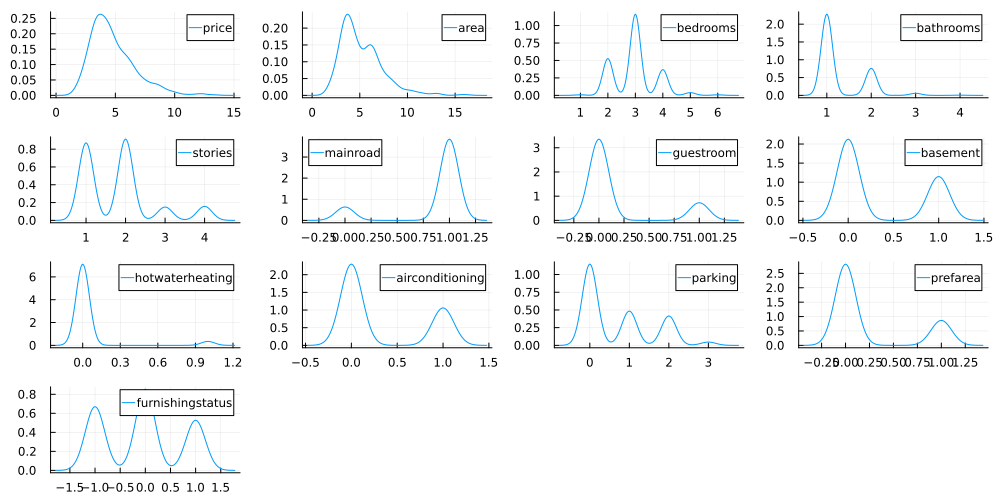

In [23]:
plot_array = [] 

for i = 1:13
    push!(plot_array, density(data[:, i], label = names(data)[i]))

end

# Combine plots into a single plot
plot(plot_array...,  legend=true)
plot!(size=(1000,500))

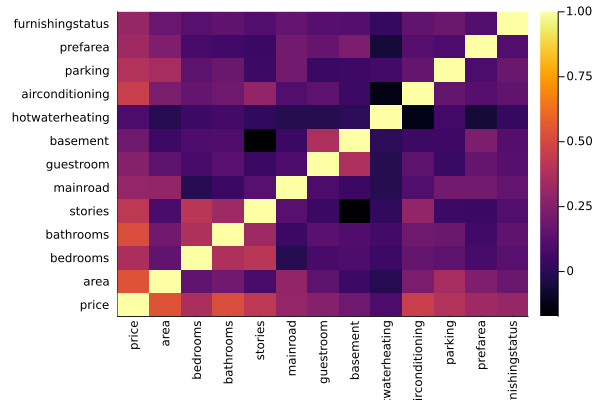

In [24]:
display(MIME"image/png"(), heatmap(names(data), names(data), cor(Matrix(data)),  xrotation=90))

Features do not corrlate much with each other. The price is highly correlated with area, number of bathrooms and air conditioning. You may decide to drop some of the features that do not correlate much with the price.

The target column of the dataset is "price" – we are interested in which case hosuing price is minimumized or maximumized. 

In [25]:
y = data[!, Symbol("price")];
X = data[:, Not(Symbol("price"))];

Now, we need to split our dataset into training and testing datasets (60% for training)

In [26]:
sample = randsubseq(1:size(data, 1), 0.6);

X_train = transpose(Array{Float32}(X[sample, :]));
y_train = transpose(Array{Float32}(y[sample, :]));
notsample = [i for i in 1:size(data,1) if isempty(searchsorted(sample, i))]
X_test= transpose(Array{Float32}(X[notsample, :]));
y_test = transpose(Array{Float32}(y[notsample, :]));

data_train = Flux.Data.DataLoader((X_train, y_train), batchsize=16);

## Initialize neural network

Generate some arbitrary neural network, loss function and optimizer of your choice.

In [84]:
model = Chain(
    Dense(size(X)[2],16, relu),
    Dense(16, 1)
)

loss(x, y) = Flux.mse(model(x), y)
opt = Adam()

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

## Training the neural network

epoch #20, training loss: 1.298584222793579, test loss: 1.262984037399292
epoch #40, training loss: 1.1579465866088867, test loss: 1.152591347694397
epoch #60, training loss: 1.129883885383606, test loss: 1.131748914718628
epoch #80, training loss: 1.1171026229858398, test loss: 1.1243815422058105
epoch #100, training loss: 1.1079154014587402, test loss: 1.1176732778549194


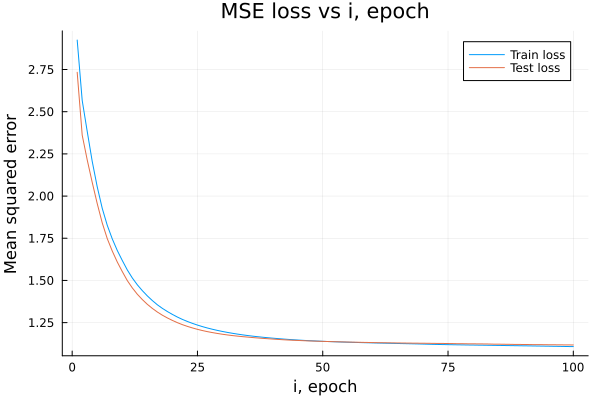

In [85]:
epochs = 100
train_losses = Float64[]
test_losses = Float64[]

for epoch in 1:epochs
    for (X_batch, y_batch) in data_train
        train!(loss, params(model), [(X_batch, y_batch)], opt);
    end
    push!(train_losses, loss(X_train, y_train));
    push!(test_losses, loss(X_test, y_test))
    if epoch%20 == 0
        println("epoch #", epoch, ", training loss: ", train_losses[end], ", test loss: ", test_losses[end])
    end
end

plot(train_losses, xlabel="i, epoch", ylabel="Mean squared error", title="MSE loss vs i, epoch", label="Train loss")
plot!(test_losses, label="Test loss")

The loss function failed to converge to 0 for both training and testing sets. It seems that either there is not enough data to learn the function or NN is not complex enough to generalize at this dataset. But just for the sake of experiment, we can see how partition-based formulation can be used to minimize or maximize the function. So, suppose that the NN is good enough to draw conclusions (better combination of learning parameters + preprocessing can be done by user). 

Suppose, we want to get a formulation of NN with 3 partitions, fast bound tightening and `equalrange` as a strategy for partition.

***Note:*** Don't forget about lower and upper bounds bounds for the input variables, which can be found by taking minimum and maximum values from the datasey for each variable.

In [86]:
init_U = maximum.(eachcol(X_train'));
init_L = minimum.(eachcol(X_train'));

Now, we want to know which input parameters produce the longest life expectancy:

In [87]:
# number of parttions set to 4 (recommended to experiment with it)
P = 4
println("Time to formulate with 'fast' bounds, 'equalsize' strategy ")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);

# we are interested in the output neuron, which is Life expectancy
output_neuron = jump_model[:x][maximum(keys(jump_model[:x].data))]
@objective(jump_model, Max, output_neuron)

println("Time to maximize model:")
@time optimize!(jump_model)
solution = [i for i in value.(jump_model[:x][0, :])]
max_price = objective_value(jump_model)
max_df = DataFrame([max_price  transpose(Array(solution))],  names(data))

vcat(max_df, DataFrame(data[argmax(data[:, 1]), :]))

Time to formulate with 'fast' bounds, 'equalsize' strategy 
  0.003893 seconds (14.73 k allocations: 918.836 KiB)
Time to maximize model:
  0.010118 seconds (4.05 k allocations: 362.484 KiB)


Row,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,13.6014,16.2,6.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0
2,13.3,7.42,4.0,2.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0


The first row is the solution found by MIP formulation and the second row is the row with maximum housing price in the dataset.

Now, lets find minimum housing price

In [88]:
println("Time to formulate with 'fast' bounds, 'equalsize' strategy ")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);
output_neuron = jump_model[:x][maximum(keys(jump_model[:x].data))]
@objective(jump_model, Min, output_neuron)


println("Time to minimize model:")
@time optimize!(jump_model)
solution = [i for i in value.(jump_model[:x][0, :])]
min_price = objective_value(jump_model)
min_df = DataFrame([min_price  transpose(Array(solution))],  names(data));

vcat(min_df, DataFrame(data[argmin(data[:, 1]), :]))

Time to formulate with 'fast' bounds, 'equalsize' strategy 
  0.001719 seconds (14.73 k allocations: 918.836 KiB)
Time to minimize model:
  0.009843 seconds (4.05 k allocations: 362.547 KiB)


Row,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.69777,1.65,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,1.75,2.91,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


The first row is the solution found by MIP formulation and the second row is the row with minimum housing price in the dataset.

Now imagine that someone is looking for the appartment with specific requirements to the housing: some number of bedrooms, bathroms, furnishsing status and etc. With this MIP formulation you can easuly find the range of prices to expect.

The customer can come to you and say something like:

***"I want a furnished flat with 3 bathroom and 1 bedroom, with airconditioning and access to the main road. What prices should I expect?"***

As a data analyst, you will train a neural network, make a MIP formulation and add additional constraints

In [89]:
P = 3
println("Time to formulate with 'fast' bounds, 'equalsize' strategy ")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);

jump_model

Time to formulate with 'fast' bounds, 'equalsize' strategy 
  0.001612 seconds (12.40 k allocations: 770.742 KiB)


A JuMP Model
Maximization problem with:
Variables: 93
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 17 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 45 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 237 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 16 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: x, z_b, Σ

In [90]:
names(data)[2:end]

12-element Vector{String}:
 "area"
 "bedrooms"
 "bathrooms"
 "stories"
 "mainroad"
 "guestroom"
 "basement"
 "hotwaterheating"
 "airconditioning"
 "parking"
 "prefarea"
 "furnishingstatus"

$x$ variables in the 0-layer of the neural network are input variables

In [91]:
jump_model[:x][0, :]

JuMP.Containers.SparseAxisArray{VariableRef, 1, Tuple{Int64}} with 12 entries:
  [1 ]  =  x[0,1]
  [2 ]  =  x[0,2]
  [3 ]  =  x[0,3]
  [4 ]  =  x[0,4]
  [5 ]  =  x[0,5]
  [6 ]  =  x[0,6]
  [7 ]  =  x[0,7]
  [8 ]  =  x[0,8]
  [9 ]  =  x[0,9]
  [10]  =  x[0,10]
  [11]  =  x[0,11]
        ⋮
  [12]  =  x[0,12]

Customer request:

***"I want a furnished flat with 2 bathroom and 2 bedroom, with airconditioning and access to the main road, parking spaces more than 2, and area should be more than 4 and less than 6. What prices should I expect?"***

Translate this as $4 \leq x_1\leq 6, x_{2} = 2, x_{3}=2, x_{5}=1, x_{9}=1, x_{11}\geq 1, x_{12} = 0$ and these additional constraints

In [92]:
@constraint(jump_model, jump_model[:x][0, 1] >= 4);
@constraint(jump_model, jump_model[:x][0, 1] <= 6);
@constraint(jump_model, jump_model[:x][0, 2] == 2);
@constraint(jump_model, jump_model[:x][0, 3] == 1);
@constraint(jump_model, jump_model[:x][0, 5] == 1);
@constraint(jump_model, jump_model[:x][0, 9] == 1);
@constraint(jump_model, jump_model[:x][0, 11] >= 1);
@constraint(jump_model, jump_model[:x][0, 12] == 1);

With these additional constraints maximize and minimize output neuron (in our case housing price)

In [93]:
output_neuron = jump_model[:x][maximum(keys(jump_model[:x].data))]

@objective(jump_model, Max, output_neuron)
@time optimize!(jump_model)
max_price = objective_value(jump_model)
max_solution = vcat(max_price, [i for i in value.(jump_model[:x][0, :])]);

@objective(jump_model, Min, output_neuron);
@time optimize!(jump_model)
min_price = objective_value(jump_model);
min_solution = vcat(min_price, [i for i in value.(jump_model[:x][0, :])]);

  0.003244 seconds (3.62 k allocations: 296.984 KiB)
  0.004838 seconds (591 allocations: 18.422 KiB)


So, with such restrictions customer can expect prices in a range of $[4.91862, 8.65459]$.

In [94]:
DataFrame(transpose(hcat(max_solution, min_solution)), names(data))

Row,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.91524,6.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0
2,4.47111,4.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


 When adding additional constraints make sure that they are strictly in the bounds defined by `init_L` and `init_U`, otherwise it is possible that the `JuMP` model would be infeasible (no solution).

In [95]:
DataFrame(transpose(hcat(init_L, init_U)), names(data)[2:end])

Row,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,1.65,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
2,16.2,6.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0


## Compatibility with other functions in the library

The `forward_pass!()` function works in the same way as with original formulation.

In [96]:
P = 3
println("Time to formulate with 'fast' bounds, 'equalsize' strategy ")
@time bounds_U, bounds_L = NN_formulate_Psplit!(jump_model, model, P, init_U, init_L);

x_sample = [1.65, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0]
println("\nOutput of NN: ", model(x_sample)[1])
println("Output of MIP formulation: ", forward_pass!(jump_model,x_sample)[1])

Time to formulate with 'fast' bounds, 'equalsize' strategy 
  0.001584 seconds (12.40 k allocations: 770.742 KiB)

Output of NN: 1.6977723
Output of MIP formulation: 1.697772228817443


If you have computed bounds, you can also compress the Neural Network using `NN_compress()`

In [97]:
model

Chain(
  Dense(12 => 16, relu),                # 208 parameters
  Dense(16 => 1),                       # 17 parameters
)                   # Total: 4 arrays, 225 parameters, 1.129 KiB.

In [99]:
compressed_model, removed = NN_compress(model,  init_U, init_L, bounds_U, bounds_L)
compressed_model


Removed 2/16 neurons


Chain(
  Dense(12 => 14, relu),                # 182 parameters
  Dense(14 => 1),                       # 15 parameters
)                   # Total: 4 arrays, 197 parameters, 1.020 KiB.

Currently the partition based formulation is not compatible with `optimize_by_sampling!()` and `optimize_by_walking!()` due to different architexture of the MIP problem, which can be updated in the future releases.